### This notebook describes the programmatic way for downloading Planet Scope Ortho Tiles (PSOrthoTiles) using a Planet API key, clipping the tile to a provided geometry and calculating the NVDI




-----

###  Step 1: Download a PlanetScope 4-band Ortho Tile given a specified geometry

In this step you will learn to 

a) Set your Planet API Key and pass it to the code as an environment variable. 


In [63]:
# Import relevant packages

import os
from os.path import join, dirname
import json
from dotenv import load_dotenv
import numpy as np
import rasterio
import requests
from requests.auth import HTTPBasicAuth
from retrying import retry
import time
from tqdm import tqdm
import zipfile

In [21]:
# Import planet API key as stored environment variable

load_dotenv('.env')

PL_API_KEY = str(os.getenv('PLANET_API_KEY'))

In [22]:
# Define geometry of study area

geojson_geometry = {
  "type": "Polygon",
  "coordinates": [
    [
      [
              -121.72562956809998,
              46.77024032708875
            ],
            [
              -121.72287225723267,
              46.77024032708875
            ],
            [
              -121.72287225723267,
              46.77120296608276
            ],
            [
              -121.72562956809998,
              46.77120296608276
            ],
            [
              -121.72562956809998,
              46.77024032708875
            ]
    ]
  ]
}

# filter for items the overlap with our chosen geometry
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geojson_geometry
}

# filter images acquired in a certain date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "2018-07-01T00:00:00.000Z",
    "lte": "2018-08-01T00:00:00.000Z"
  }
}

# filter any images which are more than 50% clouds
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 0.5
  }
}

# create a filter that combines our geo and date filters
# could also use an "OrFilter"
plot_1 = {
  "type": "AndFilter",
  "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [23]:
#gets the stats - i.e. avaliable images in the timeframe
# Stats API request object
stats_endpoint_request = {
  "interval": "day",
  "item_types": ["PSOrthoTile"],
  "filter": plot_1
}

# fire off the POST request
result = \
  requests.post(
    'https://api.planet.com/data/v1/stats',
    auth=HTTPBasicAuth(PL_API_KEY, ''),
    json=stats_endpoint_request)

print (result.text)

{"utc_offset": "+0h", "interval": "day", "buckets": [{"count": 3, "start_time": "2018-07-03T00:00:00.000000Z"}, {"count": 2, "start_time": "2018-07-05T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-09T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-11T00:00:00.000000Z"}, {"count": 2, "start_time": "2018-07-12T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-13T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-14T00:00:00.000000Z"}, {"count": 2, "start_time": "2018-07-15T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-16T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-17T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-18T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-19T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-20T00:00:00.000000Z"}, {"count": 3, "start_time": "2018-07-21T00:00:00.000000Z"}, {"count": 1, "start_time": "2018-07-22T00:00:00.000000Z"}, {"count": 2, "start_time": "2018-07-23T00:00:00.000000Z"}, {"c

In [24]:
#now lets get the metadata
# fire off the POST request
result_metadata = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(PL_API_KEY, ''),
    json=stats_endpoint_request)

print(result_metadata.text)

{"_links": {"_first": "https://api.planet.com/data/v1/searches/7af8a38f4cdf4c2db5c7232b8631c12e/results?_page=eyJxdWVyeV9wYXJhbXMiOiB7fSwgInNvcnRfcHJldiI6IGZhbHNlLCAicGFnZV9zaXplIjogMjUwLCAic29ydF9ieSI6ICJwdWJsaXNoZWQiLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9kZXNjIjogdHJ1ZX0%3D", "_next": "https://api.planet.com/data/v1/searches/7af8a38f4cdf4c2db5c7232b8631c12e/results?_page=eyJxdWVyeV9wYXJhbXMiOiB7fSwgInNvcnRfcHJldiI6IGZhbHNlLCAicGFnZV9zaXplIjogMjUwLCAic29ydF9ieSI6ICJwdWJsaXNoZWQiLCAic29ydF9zdGFydCI6ICIyMDE4LTA3LTAzVDIyOjQxOjE3LjAwMDAwMFoiLCAic29ydF9sYXN0X2lkIjogIjE1NDA5NzlfMTA2MDYxOV8yMDE4LTA3LTAzXzBmMTIiLCAic29ydF9kZXNjIjogdHJ1ZX0%3D", "_self": "https://api.planet.com/data/v1/searches/7af8a38f4cdf4c2db5c7232b8631c12e/results?_page=eyJxdWVyeV9wYXJhbXMiOiB7fSwgInNvcnRfcHJldiI6IGZhbHNlLCAicGFnZV9zaXplIjogMjUwLCAic29ydF9ieSI6ICJwdWJsaXNoZWQiLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9kZXNjIjogdHJ1ZX0%3D"}, "features": [{"_links": {"_self"

In [41]:
# Get item ids

jstl= json.loads(result_metadata.text)
for feature in jstl['features']:
    print(feature['id'])

1585833_1060619_2018-07-24_1105
1598521_1060619_2018-07-30_1054
1597891_1060619_2018-07-30_1025
1596058_1060619_2018-07-29_0f49
1595937_1060619_2018-07-29_1018
1592165_1060619_2018-07-27_0f06
1591783_1060619_2018-07-27_1040
1589654_1060619_2018-07-26_1039
1588148_1060619_2018-07-25_104d
1588057_1060619_2018-07-25_100c
1585850_1060619_2018-07-24_1033
1583967_1060619_2018-07-23_1052
1583636_1060619_2018-07-23_0e3a
1581579_1060619_2018-07-21_101f
1581603_1060619_2018-07-22_0f4e
1579873_1060619_2018-07-21_1043
1579515_1060619_2018-07-21_1003
1577610_1060619_2018-07-20_1051
1575928_1060619_2018-07-19_0f40
1573403_1060619_2018-07-18_101e
1571216_1060619_2018-07-17_0e20
1569565_1060619_2018-07-16_0f3b
1567358_1060619_2018-07-15_0f4b
1567005_1060619_2018-07-15_0f43
1564918_1060619_2018-07-14_1038
1562763_1060619_2018-07-13_1025
1561170_1060619_2018-07-12_0f2d
1560547_1060619_2018-07-12_0e0f
1558372_1060619_2018-07-11_103d
1554579_1060619_2018-07-09_1050
1546037_1060619_2018-07-05_0f33
1545409_

In [42]:
item_id = '1585833_1060619_2018-07-24_1105'
item_type = 'PSOrthoTile'
asset_type = 'analytic'

# setup auth
session = requests.Session()
session.auth = (PL_API_KEY, '')

url = ("https://api.planet.com/data/v1/item-types/" + "{}/items/{}/assets/").format(item_type, item_id)

print (url)
# request an item
#item = \
 # session.get(
  #("https://api.planet.com/data/v1/item-types/" +
   # "{}/items/{}/assets/").format(item_type, item_id))

    
item = \
  session.get(url)

# extract the activation url from the item for the desired asset
item_activation_url = item.json()[asset_type]["_links"]["activate"]

# request activation
response = session.post(item_activation_url)

print(response.status_code)

https://api.planet.com/data/v1/item-types/PSOrthoTile/items/1585833_1060619_2018-07-24_1105/assets/
202


In [43]:
# Double check if item is active
item.json()[asset_type]["status"]

'activating'

In [55]:
payload = {
    "aoi" : geojson_geometry,
    "targets" : [{
        "item_id" : item_id, 
        "item_type" : item_type, 
        "asset_type" : asset_type
    }]
}

request = requests.post('https://api.planet.com/compute/ops/clips/v1', auth=(PL_API_KEY, ''), json=payload)
clip_url = request.json()['_links']['_self']

clip_succeeded = False
while not clip_succeeded:

    # Poll API
    check_state_request = requests.get(clip_url, auth=(PL_API_KEY, ''))
    
    # If clipping process succeeded , we are done
    if check_state_request.json()['state'] == 'succeeded':
        clip_download_url = check_state_request.json()['_links']['results'][0]
        clip_succeeded = True
        print("Clip of scene succeeded and is ready to download") 
    
    # Still activating. Wait 1 second and check again.
    else:
        print("...Still waiting for clipping to complete...")
        time.sleep(1)

...Still waiting for clipping to complete...
...Still waiting for clipping to complete...
...Still waiting for clipping to complete...
Clip of scene succeeded and is ready to download


In [62]:
response = requests.get(clip_download_url, stream=True)
with open(item_id + '.zip', "wb") as handle:
    for data in tqdm(response.iter_content()):
        handle.write(data)

# Unzip file
zipped_item = zipfile.ZipFile(item_id + '.zip')
zipped_item.extractall(item_id)    
  
# Delete zip file
os.remove(item_id + '.zip')
print('Downloaded clips located in local directory')

31302it [00:00, 84698.59it/s]

Downloaded clips located in: output/


### Step 2. Extract the data from the red and near-infrared bands

In this step, you'll use Rasterio, a Python library for reading and writing geospatial raster datasets, to open the raster image you downloaded (the .tif file). Then you'll extract the data from the red and near-infrared bands and load the band data into arrays that you can manipulate using Python's NumPy libary. Note: in PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared.

In [64]:
import rasterio
import numpy as np

filename = "1585833_1060619_2018-07-24_1105_BGRN_Analytic_clip.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(filename) as src:
    band_red = src.read(3)

with rasterio.open(filename) as src:
    band_nir = src.read(4)

In [65]:
from xml.dom import minidom

xmldoc = minidom.parse("1585833_1060619_2018-07-24_1105_BGRN_Analytic_metadata_clip.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

In [67]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

# check range NDVI values, excluding NaN
np.nanmin(ndvi), np.nanmax(ndvi)

(0.3763535124385521, 0.646973199481431)

In [68]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

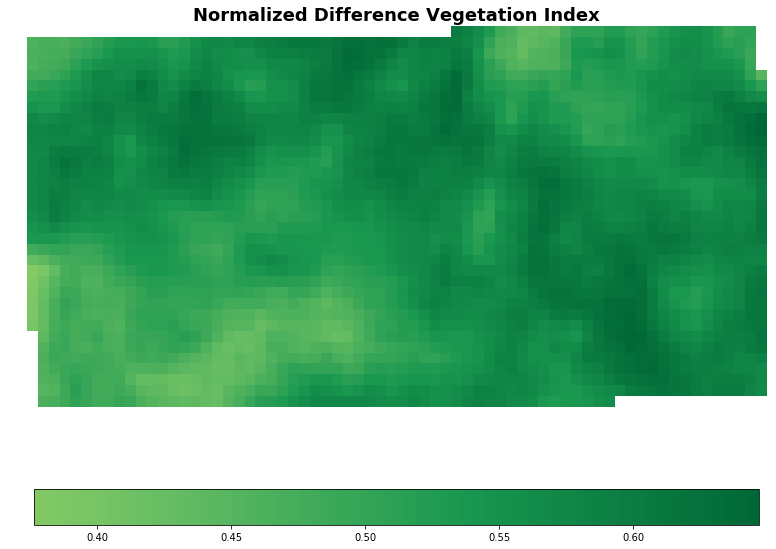

In [72]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

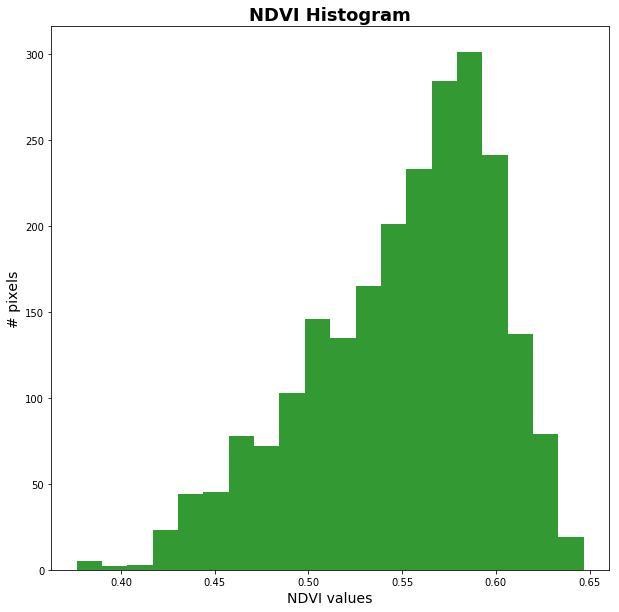

In [70]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()